In [47]:
# Step 1.0 - Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, auc)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [48]:
import warnings
warnings.filterwarnings("ignore")

- Loading the dataset

In [49]:
data = pd.read_csv("RTA Dataset.csv")
data.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


- Viewing the columns contained in my dataset

In [ ]:
print("\nCOLUMN NAMES:")
data.columns


COLUMN NAMES:


Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

- Shaping my datset in column row format

In [8]:
data.shape

(12316, 32)

- Checking for mising values

In [11]:
data.isnull().sum()

Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                    0
Sex_of_casualty                   0
Age_band_of_casualty              0
Casualty_severity                 0
Work_of_casuality           

- Dealing with missing values

In [ ]:
# drop columns with >50% missing
th = 0.5
cols_keep = data.columns[data.isnull().mean() < th]
data = data[cols_keep]

# fill categorical misses with "Unknown"
for c in data.select_dtypes(include='object').columns:
    data[c] = data[c].fillna("Unknown")

# if Time exists, extract hour
if "Time" in data.columns:
    try:
        data["Hour"] = pd.to_datetime(data["Time"], errors='coerce').dt.hour
        data["Hour"].fillna(data["Hour"].median(), inplace=True)
    except:
        pass

- Dropping the unecesary cloumns

- Many casuality fields apply only when injuries occur thus they cause noise and having too many missing values which we don't want to use in this process

- Showing statistics of our dataset

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity,Hour
count,12316,12316,12316,12316,12316,12316,12316,12316,12316,12316,...,12316,12316,12316,12316,12316,12316,12316,12316,12316,12316.000000
unique,1074,7,5,3,7,4,8,18,5,6,...,4,3,6,4,7,6,9,20,3,NaN
top,15:30:00,Friday,18-30,Male,Junior high school,Employee,5-10yr,Automobile,Owner,Unknown,...,Driver or rider,Male,na,3,Driver,Normal,Not a Pedestrian,No distancing,Slight Injury,NaN
freq,120,2041,4271,11437,7619,9627,3363,3205,10459,6811,...,4944,5253,4443,7076,5903,9608,11390,2263,10415,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.835823
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.202923
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.000000


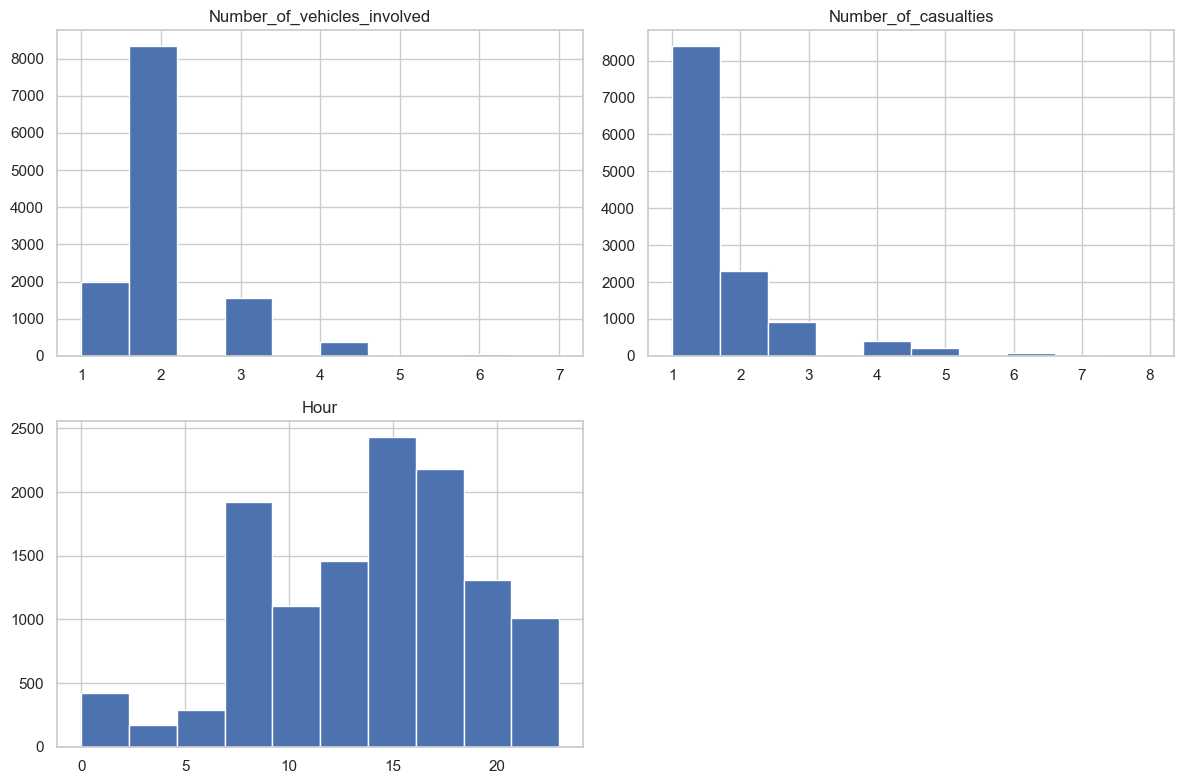

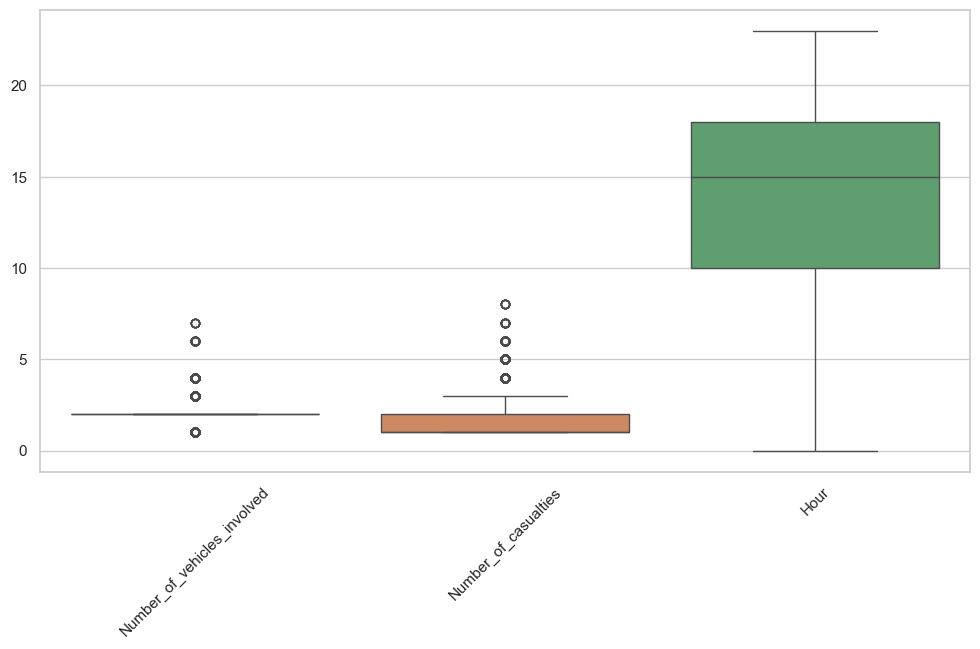


Value counts for: Time
Time
15:30:00    120
17:10:00    110
18:30:00    103
11:30:00     99
17:00:00     98
16:00:00     97
18:00:00     95
19:00:00     94
17:50:00     88
17:25:00     87
Name: count, dtype: int64

Value counts for: Day_of_week
Day_of_week
Friday       2041
Thursday     1851
Wednesday    1840
Tuesday      1770
Monday       1681
Saturday     1666
Sunday       1467
Name: count, dtype: int64

Value counts for: Age_band_of_driver
Age_band_of_driver
18-30       4271
31-50       4087
Over 51     1585
Unknown     1548
Under 18     825
Name: count, dtype: int64

Value counts for: Sex_of_driver
Sex_of_driver
Male       11437
Female       701
Unknown      178
Name: count, dtype: int64

Value counts for: Educational_level
Educational_level
Junior high school    7619
Elementary school     2163
High school           1110
Unknown                841
Above high school      362
Writing & reading      176
Illiterate              45
Name: count, dtype: int64

Value counts for: Vehicle_d

In [51]:
# basic describe
display(data.describe(include='all'))

# numeric histograms
nums = data.select_dtypes(include='number').columns.tolist()
if len(nums) > 0:
    data[nums].hist(figsize=(12,8))
    plt.tight_layout()
    plt.show()

# boxplots to check for outliers 
if len(nums) > 0:
    plt.figure(figsize=(12,6))
    sns.boxplot(data=data[nums].fillna(0))
    plt.xticks(rotation=45)
    plt.show()

# frequency for main categorical variables
cats = data.select_dtypes(include='object').columns.tolist()
for c in cats[:6]:
    print("\nValue counts for:", c)
    print(data[c].value_counts().head(10))

- Handling outliers.

In [ ]:
numeric_cols = data.select_dtypes(include='number').columns.tolist()

for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # capping the values
    data[col] = np.where(data[col] < lower, lower,
                       np.where(data[col] > upper, upper, data[col]))

print("Outlier capping completed.")


Outlier capping completed.


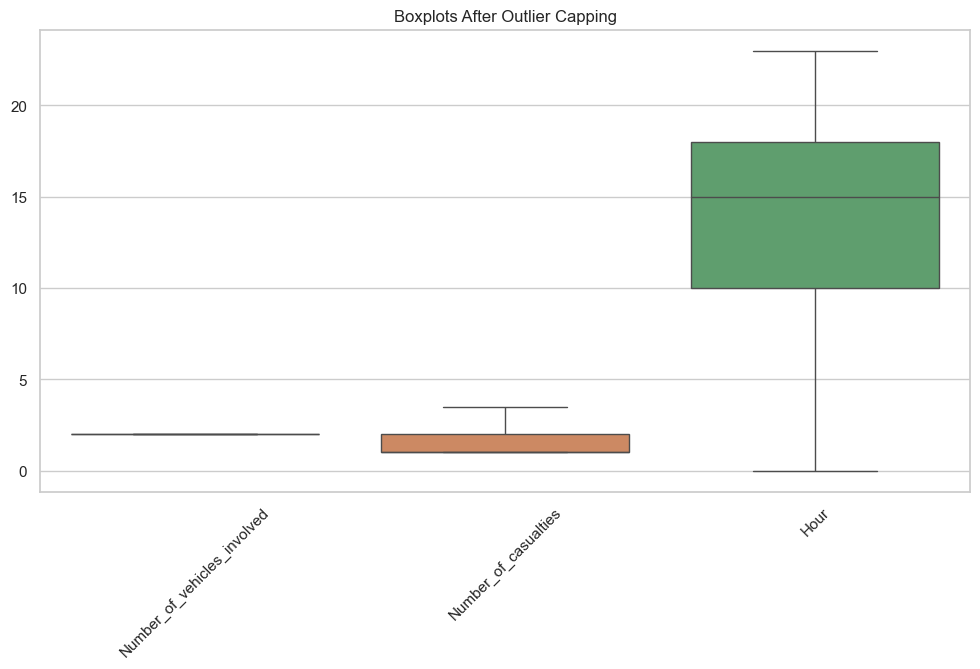

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data[numeric_cols])
plt.xticks(rotation=45)
plt.title("Boxplots After Outlier Capping")
plt.show()


- Correlation heatmap for numerical features

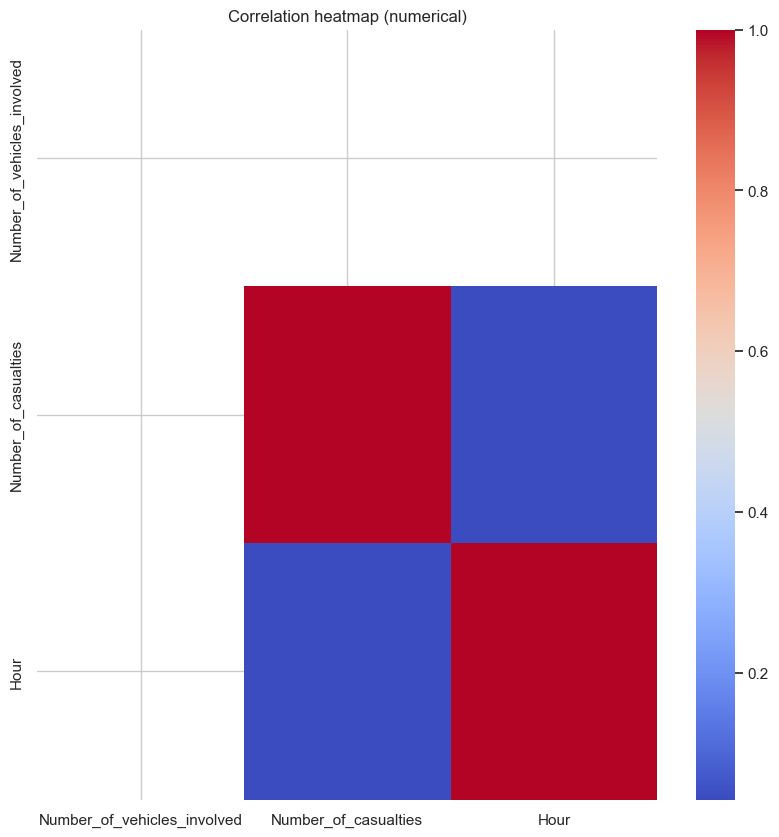

In [56]:
if len(nums) > 1:
    plt.figure(figsize=(10,10))
    sns.heatmap(data[nums].corr(), cmap='coolwarm')
    plt.title("Correlation heatmap (numerical)")
    plt.show()

- Selecting the appriopriate features

In [57]:
# ensure target name; change if different
target_col = "Accident_severity"
if target_col not in data.columns:
    raise ValueError(f"{target_col} not found in dataframe columns")

# encode target
le = LabelEncoder()
data[target_col] = le.fit_transform(data[target_col])

# one-hot encode (drop first to limit dims)
X = pd.get_dummies(data.drop(columns=[target_col]), drop_first=True)
y = data[target_col].copy()

X.shape, y.shape

((12316, 1259), (12316,))

- Feature scaling

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Mutual information for feature ranking
mi = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_df = pd.DataFrame({"feature": X.columns, "mi": mi}).sort_values("mi", ascending=False)
mi_df.head(20)

- Splitting the dataset into training and testing data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (9852, 159)
Test set shape: (2464, 159)


- Scaling the features  to ensure features with different units/ranges contribute comparably, improving optimization speed/stability for gradient-based models.

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

- Building the neural network

In [21]:

# Architecture chosen for accuracy + stability
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 accident severity classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,915 (120.76 KB)

 Trainable params: 30,915 (120.76 KB)

 Non-trainable params: 0 (0.00 B)

- Traiing the model

In [35]:
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9684 - loss: 0.0830 - val_accuracy: 0.8097 - val_loss: 1.1495
Epoch 2/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9735 - loss: 0.0711 - val_accuracy: 0.8082 - val_loss: 1.1972
Epoch 3/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9754 - loss: 0.0691 - val_accuracy: 0.8108 - val_loss: 1.2678
Epoch 4/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9769 - loss: 0.0681 - val_accuracy: 0.8062 - val_loss: 1.2232
Epoch 5/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9744 - loss: 0.0709 - val_accuracy: 0.8118 - val_loss: 1.2009
Epoch 6/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9796 - loss: 0.0592 - val_accuracy: 0.8052 - val_loss: 1.2753
Epoch 7/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9731 - loss: 0.0715 - val_accuracy: 0.8062 - val_loss: 1.2164
Epoch 8/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9784 - loss: 0.0615 - val_accuracy: 0.

- Model Evaluation

In [36]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8121 - loss: 1.3726
Test Accuracy: 0.8120941519737244


- Confusion matrix and a report

In [40]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.19      0.07      0.11       349
           2       0.85      0.95      0.90      2084

    accuracy                           0.81      2464
   macro avg       0.35      0.34      0.33      2464
weighted avg       0.75      0.81      0.77      2464


Confusion Matrix:
[[   0    3   28]
 [   0   26  323]
 [   3  106 1975]]


- Training curve plots for the model

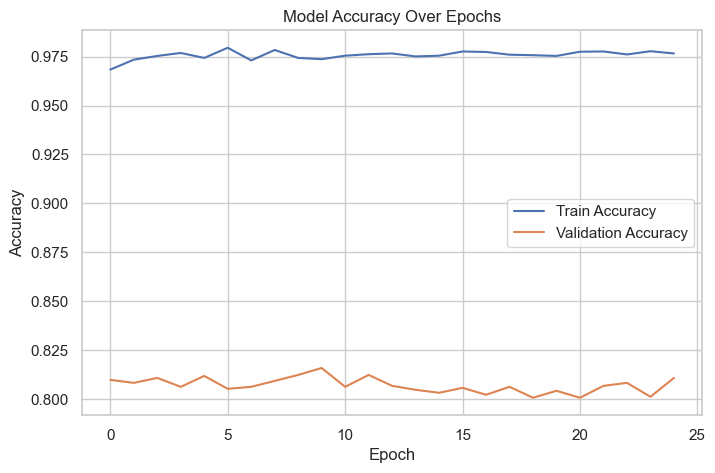

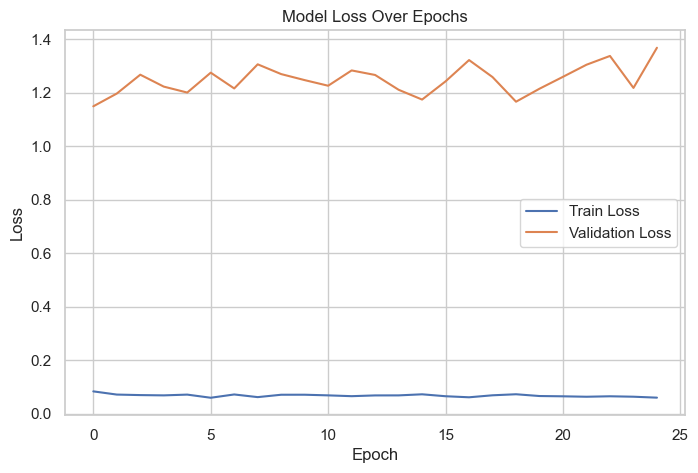

In [38]:
# Model Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Model Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


- Saving the model

In [ ]:
model.save("model1.h5")